In [10]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os

In [11]:
plt.rcParams["figure.figsize"] = (15,12)

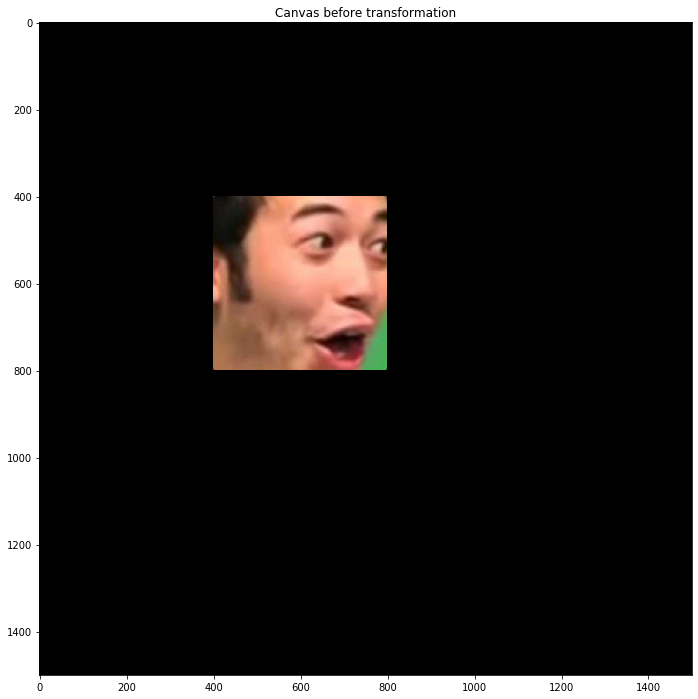

In [12]:
canvas = np.zeros((1500,1500,3),dtype='uint8')

impath = 'img/pog_400x400.jpg'
pogimg = Image.open(impath)
pogarr = np.array(pogimg)

pogy, pogx, _ = pogarr.shape
pogyoffset, pogxoffset = 400, 400

canvas_orig = canvas.copy()
canvas_orig[pogyoffset:pogy+pogyoffset,pogxoffset:pogx+pogxoffset] += pogarr


plt.imshow(canvas_orig)
plt.title('Canvas before transformation')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_orig.png")
plt.show()

In [4]:
# example translation by 600px to right and 300px to bottom

# For X' = X + t method
t = np.array([600,300]).T # Translation vector
'''
thus X + t yields:
    x' = x + 600
    y' = y + 600
'''

# For X' = [I t] * X¯
# as X¯ is augmented point
t_2_3 = np.zeros((2,3))
t_2_3[:,:2] = np.identity(2)
t_2_3[:,2] = t
'''
t_2_3 = [1 0 600]
        [0 1 300]
        
thus t_2_3 @ X yields:
    x' = 1*x + 0*y + 600 = x + 600
    y' = 0*x + 1*y + 300 = y + 300
'''

# For X¯' = [I  t] * X¯
#           [0T 1]
# as X¯ is augmented point
t_3_3 = np.identity(3)
t_3_3[:2,2] = t
t_3_3[2,:2] = np.zeros((1,2))
'''
t_3_3 = [1 0 600]
        [0 1 300]
        [0 0 1  ]
        
thus t_3_3 @ X yields:
    x' = 1*x + 0*y + 600 = x + 600
    y' = 0*x + 1*y + 300 = y + 300
    w' = 0*x + 0*y + 1   = 1
    
Since w` is also 1, it is still considered augmented point though it can be replaced with homogenous point x~
'''

"\nt_3_3 = [1 0 600]\n        [0 1 300]\n        [0 0 1  ]\n        \nthus t_3_3 @ X yields:\n    x' = 1*x + 0*y + 600 = x + 600\n    y' = 0*x + 1*y + 300 = y + 300\n    w' = 0*x + 0*y + 1   = 1\n    \nSince w` is also 1, it is still considered augmented point though it can be replaced with homogenous point x~\n"

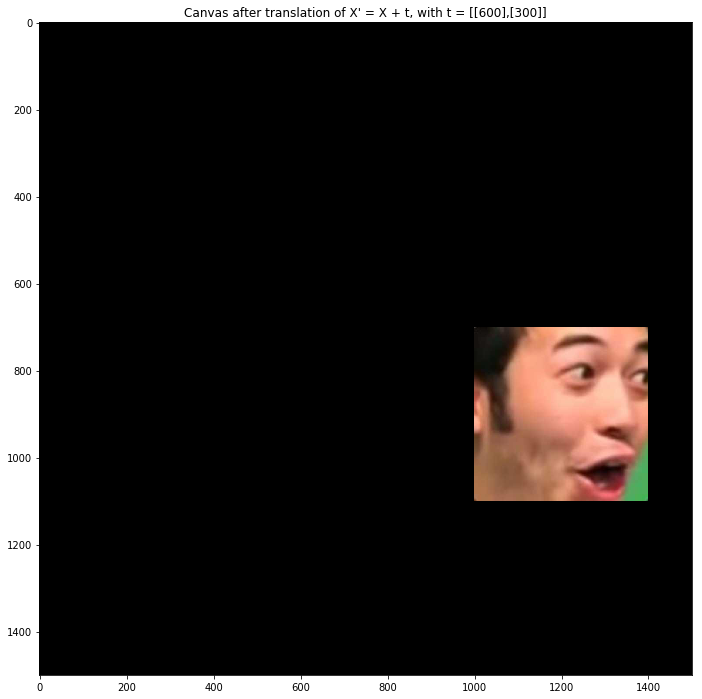

In [5]:
canvas_trans_01 = canvas.copy()
t_x, t_y = t
for y in range(pogyoffset,pogy+pogyoffset):
    y_nu = y + t_y
    for x in range(pogxoffset,pogx+pogxoffset):
        x_nu = x + t_x
        canvas_trans_01[y_nu,x_nu]=canvas_orig[y,x]

plt.imshow(canvas_trans_01)
plt.title('Canvas after translation of X\' = X + t, with t = [[600],[300]]')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_trans_01.png")
plt.show()

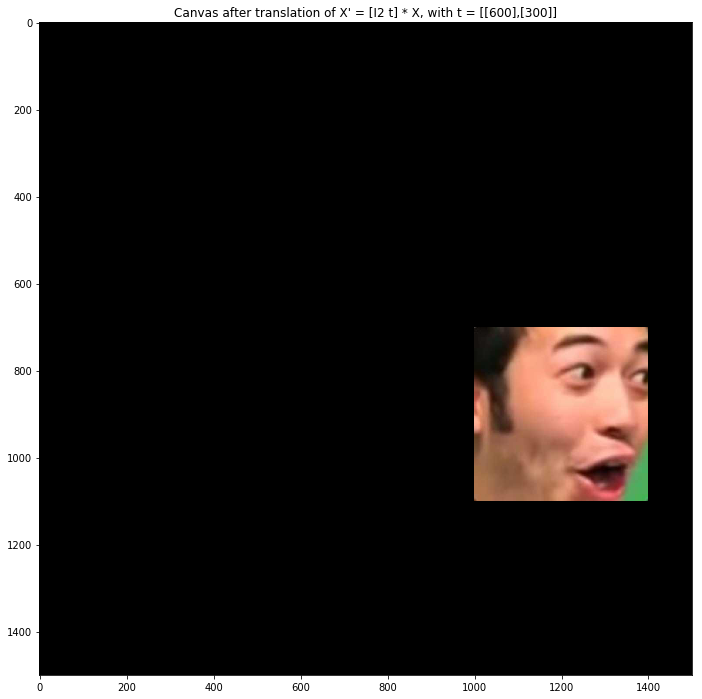

In [6]:
canvas_trans_02 = canvas.copy()
for y in range(pogyoffset,pogy+pogyoffset):
    for x in range(pogxoffset,pogx+pogxoffset):
        x_nu, y_nu = t_2_3 @ np.array([x, y, 1]).T
        canvas_trans_02[int(y_nu),int(x_nu)]=canvas_orig[y,x]

plt.imshow(canvas_trans_02)
plt.title('Canvas after translation of X\' = [I2 t] * X, with t = [[600],[300]]')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_trans_02.png")
plt.show()

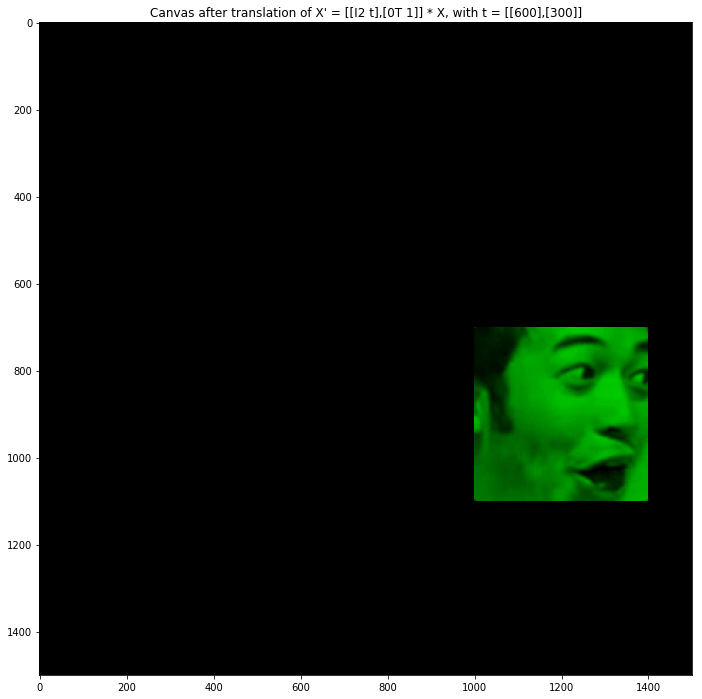

In [7]:
canvas_trans_03 = canvas.copy()
for y in range(pogyoffset,pogy+pogyoffset):
    for x in range(pogxoffset,pogx+pogxoffset):
        x_nu, y_nu, w_nu = t_3_3 @ np.array([x, y, 1]).T
        canvas_trans_03[int(y_nu),int(x_nu),int(w_nu)]=canvas_orig[y,x,1]

plt.imshow(canvas_trans_03)
plt.title('Canvas after translation of X\' = [[I2 t],[0T 1]] * X, with t = [[600],[300]]')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_trans_03.png")
plt.show()

In [8]:
# https://mathworld.wolfram.com/AffineTransformation.html
def affine_rot_scale(xs,ys,xsoffset,ysoffset,scale=1,theta=0,xa=0,ya=0,canvas_orig=canvas_orig):
    rot_mat = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    canvas_affine = canvas.copy()
    for y in range(ysoffset,ys+ysoffset):
        for x in range(xsoffset,xs+xsoffset):
            nu_x, nu_y = \
                scale * \
                rot_mat @ \
                np.array([x-xa,y-ya]).T
            canvas_affine[int(nu_y),int(nu_x)] = canvas_orig[y,x]
    return canvas_affine

In [ ]:
rot_s = 1.2
rot_theta = np.pi*.1
rot_t = np.array([0, 0]).T

rot_mat = np.identity(3)
rot_mat[:2,:2] = s * np.array([
    [np.cos(rot_theta), -np.sin(rot_theta)],
    [np.sin(rot_theta), np.cos(rot_theta)]
])
rot_mat[:2,2] = rot_t

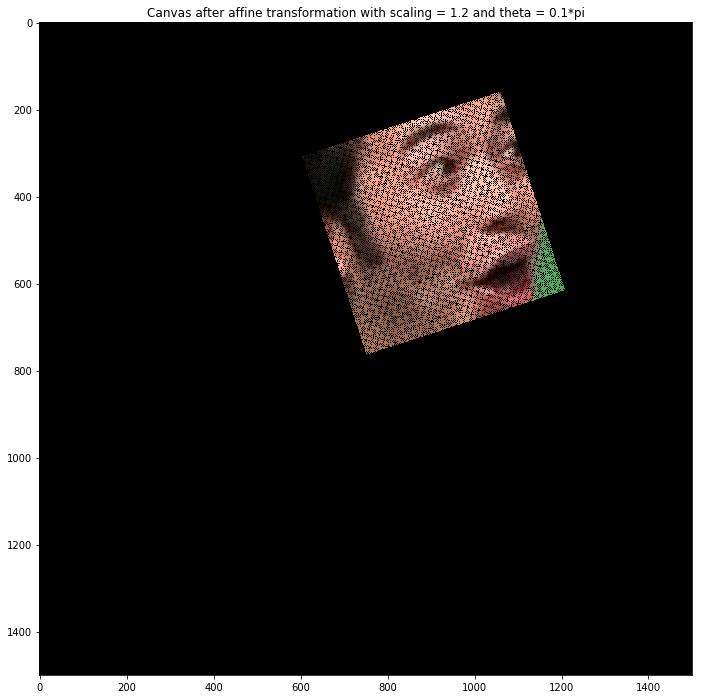

In [9]:
canvas_affine = affine_rot_scale(
    pogx,
    pogy,
    pogxoffset,
    pogyoffset,
    scale=1.2,
    theta=np.pi*0.1
)
plt.imshow(canvas_affine)
plt.title('Canvas after affine transformation with scaling = 1.2 and theta = 0.1*pi')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_affine.png")
plt.show()

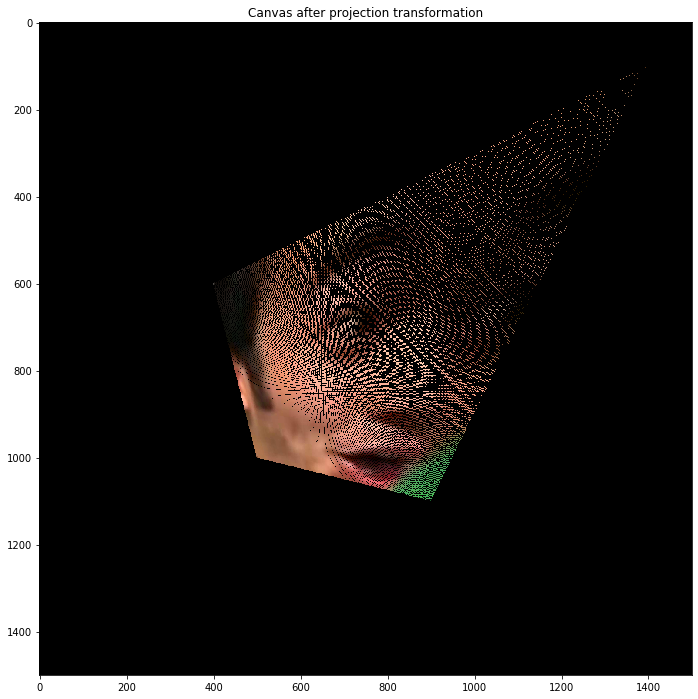

In [17]:
# http://www.fmwconcepts.com/imagemagick/bilinearwarp/FourCornerImageWarp2.pdf

# So basically the original image has 4 corners:
c_tl_or = np.array([pogxoffset, pogyoffset, 1]).T
c_tr_or = np.array([pogxoffset+pogx, pogyoffset, 1]).T
c_bl_or = np.array([pogxoffset, pogyoffset+pogy, 1]).T
c_br_or = np.array([pogxoffset+pogx, pogyoffset+pogy, 1]).T
c_or_arr = [c_tl_or, c_tr_or, c_bl_or, c_br_or]
# And i want to project perspectively it to:
c_tl_tg = np.array([400, 600, 1]).T
c_tr_tg = np.array([1400, 100, 1]).T
c_bl_tg = np.array([500, 1000, 1]).T
c_br_tg = np.array([900, 1100, 1]).T
c_tg_arr = [c_tl_tg, c_tr_tg, c_bl_tg, c_br_tg]

# https://engineering.purdue.edu/kak/computervision/ECE661Folder/Lecture10.pdf

canvas_proj = canvas.copy()

# https://math.stackexchange.com/questions/494238/how-to-compute-homography-matrix-h-from-corresponding-points-2d-2d-planar-homog
# https://www.tutorialspoint.com/numpy/numpy_inv.htm

def expand_p_to_mat(p_or, p_tg):
    x_or, y_or, _ = p_or.T
    x_tg, y_tg, _ = p_tg.T
    return np.array([
        [-x_or, -y_or, -1, 0, 0, 0, x_or*x_tg, y_or*x_tg, x_tg],
        [0, 0, 0, -x_or, -y_or, -1, x_or*y_tg, y_or*y_tg, y_tg]
    ])

def stack_p(p_or_arr, p_tg_arr):
    n = len(p_or_arr)
    out = np.zeros(((2*n)+1, 9))
    for i in range(n):
        out[i*2:i*2+2,:] = expand_p_to_mat(p_or_arr[i],p_tg_arr[i])
    out[-1,-1]=1
    return out

c_P = stack_p(c_or_arr, c_tg_arr)
c_0 = np.zeros(9)
c_0[-1]=1
c_H = (np.linalg.inv(c_P) @ c_0.T).reshape(3,3)

for y in range(pogyoffset,pogy+pogyoffset):
    for x in range(pogxoffset,pogx+pogxoffset):
        nu_wx, nu_wy, nu_w = c_H @ np.array([x, y, 1]).T
        #print(int(nu_wx), int(nu_wy), int(nu_w), '|', int(nu_wx/nu_w), int(nu_wy/nu_w))
        canvas_proj[int(np.round(nu_wy/nu_w))%1500,int(np.round(nu_wx/nu_w))%1500]=canvas_orig[y,x]

plt.imshow(canvas_proj)
plt.title('Canvas after projection transformation')
plt.savefig(f"dump/{impath[impath.rindex('/'):impath.index('.')]}_proj.png")
plt.show()

In [15]:
lluth_A = [np.array([0,0,1]).T,np.array([0,800,1]).T,np.array([450,0,1]).T,np.array([450,800,1]).T]
lluth_B = [np.array([221, 258,1]).T, np.array([281, 524,1]).T,np.array([354, 241,1]).T, np.array([395, 537,1]).T]

lluth_P = stack_p(lluth_A, lluth_B)
lluth_0 = np.zeros(9)
lluth_0[-1]=1
lluth_H = (np.linalg.inv(c_P) @ c_0.T).reshape(3,3)

lluth_H

array([[ 5.55555556e-02, -3.61111111e-01,  4.00000000e+02],
       [-3.61111111e-01,  5.55555556e-02,  4.00000000e+02],
       [-5.55555556e-04, -5.55555556e-04,  1.00000000e+00]])

In [16]:
lluth_A

[array([0, 0, 1]),
 array([  0, 800,   1]),
 array([450,   0,   1]),
 array([450, 800,   1])]

In [22]:
lluth_H

array([[ 9.75000000e-01, -6.56250000e-01,  1.65000000e+02],
       [ 1.42108547e-16,  8.87500000e-01, -2.90000000e+02],
       [ 3.50680169e-19, -8.75000000e-04,  1.00000000e+00]])